## CSRD Data Points 

In [29]:
%pip install pandas langchain jq langchain-openai langchain-core

Note: you may need to restart the kernel to use updated packages.


In [44]:

import pandas as pd 
from dotenv import load_dotenv
import json 
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain import hub
from langchain.chat_models import init_chat_model
import os

In [32]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [33]:
vector_store = InMemoryVectorStore(embeddings)

In [45]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

/var/folders/87/9dqc4s4d7vv8wl84d0yy35tw0000gn/T/ipykernel_75474/2707928444.py:1: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  llm = init_chat_model("gpt-4o-mini", model_provider="openai")


### Load/Parse Raw Excel Data to JSON 

In [3]:
sheets_df = pd.read_excel('data/esrs_datav3.xlsx', sheet_name=None)

In [4]:
sheets_data = {sheet_name: sheet.to_dict(orient="records") for sheet_name, sheet in sheets_df.items()}

file_path = "data/csrd_datapoints.json"

if not os.path.exists(file_path):
    with open(file_path, "w", encoding="utf-8") as json_file:
        json.dump(sheets_data, json_file, indent=4, ensure_ascii=False)
    print("Data saved to csrd_datapoints.json")
else: 
    print(f"File {file_path} already exists")


File data/csrd_datapoints.json already exists


In [5]:
data = None 

with open(file_path, "r", encoding="utf-8") as json_file:
    data = json.load(json_file)

In [15]:
def convert_json_to_docs(data):
    for item in data:
        docs = []
        for _item in data[item]:
            docs.append(Document(page_content=json.dumps(_item)))
        return docs 

In [16]:
docs = convert_json_to_docs(data)

In [24]:
print(docs[0].page_content[:500])

{"ID": "BP-1_01", "ESRS": "ESRS 2", "DR": "BP-1", "Paragraph": "5 a", "Related AR": NaN, "Name": "Basis for preparation of sustainability statement", "Data Type": "semi-narrative", "Conditional or alternative DP": NaN, "May \n[V]": NaN, "Appendix B - ESRS 2 \n(SFDR + PILLAR 3 + Benchmark + CL)": NaN, "DPs to be disclosed in case of phased-in [Appendix C - ESRS 1]\nUndertaking less than 750 employees": NaN, "Appendix C - ESRS 1\n[DPs subject to phased-in]\n": NaN}


In [35]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

doc_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(doc_splits)} sub-documents.")

Split blog post into 146 sub-documents.


In [36]:
doc_ids = vector_store.add_documents(doc_splits)

print(doc_ids[:5])

['d5eef20e-846e-44d8-83ef-41deea3ead12', 'a6b8a659-14de-406b-b4ac-c1ca99700982', '7392b738-e6c9-4114-918a-d35544bca66f', 'ef7cb713-3961-45ea-b239-914a1f7cc409', '89108cc0-21cd-463f-be48-b36d8346715f']


In [38]:
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [39]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [46]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [47]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

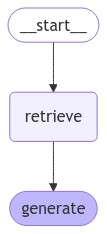

In [48]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
result = graph.invoke({"question": "What are the 5 main datapoints for ESRS 2?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='d96f712a-a2a6-41d6-a0a0-a4a8fc401537', metadata={'start_index': 0}, page_content='{"ID": "SBM-1_24", "ESRS": "ESRS 2", "DR": "SBM-1", "Paragraph": "41", "Related AR": NaN, "Name": "List of ESRS sectors that are significant for undertaking", "Data Type": "semi-narrative", "Conditional or alternative DP": "Conditional", "May \\n[V]": NaN, "Appendix B - ESRS 2 \\n(SFDR + PILLAR 3 + Benchmark + CL)": NaN, "DPs to be disclosed in case of phased-in [Appendix C - ESRS 1]\\nUndertaking less than 750 employees": NaN, "Appendix C - ESRS 1\\n[DPs subject to phased-in]\\n": NaN}'), Document(id='d5eef20e-846e-44d8-83ef-41deea3ead12', metadata={'start_index': 0}, page_content='{"ID": "BP-1_01", "ESRS": "ESRS 2", "DR": "BP-1", "Paragraph": "5 a", "Related AR": NaN, "Name": "Basis for preparation of sustainability statement", "Data Type": "semi-narrative", "Conditional or alternative DP": NaN, "May \\n[V]": NaN, "Appendix B - ESRS 2 \\n(SFDR + PILLAR 3 + Benchmark + CL)": NaN, "